<a href="https://colab.research.google.com/github/Vicente-Hernandez/puntuacion-predictiva-leads/blob/main/sistema_lead_scoring_predictivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
"""
SISTEMA DE PREDICCIÓN DE CONVERSIÓN DE LEADS - LEAD SCORING PREDICTIVO
=======================================================================
Proyecto de Machine Learning para optimizar conversión de ventas
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, accuracy_score,
                             precision_recall_curve, f1_score)
import os

# Configuración de visualización profesional
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

### **CARGA Y PREPARACIÓN DE DATOS**

In [12]:
# ============================================================================
# 1. CARGA Y PREPARACIÓN DE DATOS
# ============================================================================

print("="*80)
print("SISTEMA DE LEAD SCORING PREDICTIVO")
print("="*80)

try:
    df = pd.read_excel('simulacion_ventas.xlsx')
    print(f"\nDatos cargados: {len(df)} registros")
    print(f"Variables disponibles: {len(df.columns)}")
except FileNotFoundError:
    print("\nError: El archivo 'leads_ventas.csv' no fue encontrado. Asegúrate de que esté en el directorio correcto.")
    exit()

# Crear variable objetivo binaria para EDA y Modelado
df['conversion'] = df['decision_final'].apply(
    lambda x: 1 if 'COMPRA EXITOSA' in str(x) else 0
)

SISTEMA DE LEAD SCORING PREDICTIVO

Datos cargados: 2500 registros
Variables disponibles: 35


### **2. ANÁLISIS EXPLORATORIO DE DATOS (EDA)**

In [3]:
# ============================================================================
# 2. ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# ============================================================================

print("\n" + "="*80)
print("ANÁLISIS EXPLORATORIO DE DATOS")
print("="*80)

# Crear directorio para guardar gráficos del EDA
if not os.path.exists('eda_plots'):
    os.makedirs('eda_plots')

# Distribución de conversiones
tasa_conversion = df['conversion'].mean() * 100
print(f"\nTASA DE CONVERSIÓN GENERAL: {tasa_conversion:.2f}%")
print("\nDistribución de resultados (variable objetivo):")
print(df['conversion'].value_counts())

# --- Análisis Visual Comparativo por Segmento ---
print("\nGenerando análisis visuales por segmento...")

segmentos_categoricos = ['perfil_financiero', 'gse', 'tipo_cliente', 'intencion', 'lead_categoria']
for segmento in segmentos_categoricos:
    if segmento in df.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=segmento, hue='conversion', order=df[segmento].value_counts().index)
        plt.title(f'Conversión por {segmento.replace("_", " ").title()}', fontweight='bold')
        plt.ylabel("Cantidad de Leads")
        plt.xlabel(segmento.replace("_", " ").title())
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f'eda_plots/conversion_por_{segmento}.png', dpi=150)
        plt.close()

print("Visualizaciones de segmentos guardadas en la carpeta 'eda_plots'.")

# --- Análisis de Variables Numéricas ---
features_numericas_eda = [
    'edad', 'ingreso_mensual', 'nivel_endeudamiento', 'lead_score',
    'numero_empleados', 'ventas_anuales_uf'
]
features_numericas_eda = [f for f in features_numericas_eda if f in df.columns]

if features_numericas_eda:
    print("\nAnálisis descriptivo de variables numéricas:")
    print(df[features_numericas_eda].describe().round(2))

    # Matriz de Correlación
    plt.figure(figsize=(10, 8))
    corr_matrix = df[features_numericas_eda + ['conversion']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
    plt.title('Mapa de Calor de Correlaciones', fontweight='bold')
    plt.tight_layout()
    plt.savefig('eda_plots/matriz_correlacion.png', dpi=150)
    plt.close()
    print("Matriz de correlación guardada en la carpeta 'eda_plots'.")


ANÁLISIS EXPLORATORIO DE DATOS

TASA DE CONVERSIÓN GENERAL: 52.88%

Distribución de resultados (variable objetivo):
conversion
1    1322
0    1178
Name: count, dtype: int64

Generando análisis visuales por segmento...
Visualizaciones de segmentos guardadas en la carpeta 'eda_plots'.

Análisis descriptivo de variables numéricas:
          edad  ingreso_mensual  nivel_endeudamiento  lead_score  \
count  2367.00          2367.00              2367.00     2500.00   
mean     43.12       2118814.11                 0.29       52.75   
std      10.01       1770417.56                 0.13       24.43   
min      26.00        800000.00                 0.10       15.00   
25%      35.00       1098500.00                 0.21       40.00   
50%      42.00       1362000.00                 0.26       55.00   
75%      51.00       2213500.00                 0.33       65.00   
max      70.00       8975000.00                 0.75      100.00   

       numero_empleados  ventas_anuales_uf  
count      

### **FEATURE ENGINEERING Y PREPARACIÓN**

In [4]:
# ============================================================================
# 3. FEATURE ENGINEERING Y PREPARACIÓN
# ============================================================================

print("\n" + "="*80)
print("PREPARACIÓN DE VARIABLES PARA MODELAMIENTO")
print("="*80)

# Selección de features relevantes
features_numericas = [
    'edad', 'ingreso_mensual', 'nivel_endeudamiento',
    'lead_score', 'numero_empleados', 'ventas_anuales_uf'
]
features_categoricas = [
    'gse', 'tipo_cliente', 'perfil_financiero', 'tiene_propiedad',
    'tiene_vehiculo', 'intencion', 'preferencia_pago',
    'lead_categoria', 'clasificacion_empresa'
]

# Filtrar features que existen en el dataset
features_numericas = [f for f in features_numericas if f in df.columns]
features_categoricas = [f for f in features_categoricas if f in df.columns]

print(f"\nFeatures numéricas seleccionadas: {len(features_numericas)}")
print(f"Features categóricas seleccionadas: {len(features_categoricas)}")

# Preparar dataset para modelamiento
df_model = df[features_numericas + features_categoricas + ['conversion']].copy()

# Imputar valores faltantes
for col in features_numericas:
    df_model[col] = df_model[col].fillna(df_model[col].median())
for col in features_categoricas:
    df_model[col] = df_model[col].fillna('UNKNOWN')

# Crear variables derivadas
if 'ingreso_mensual' in df_model.columns and 'nivel_endeudamiento' in df_model.columns:
    # Evitar capacidad de pago negativa si endeudamiento > 1
    df_model['nivel_endeudamiento_capped'] = df_model['nivel_endeudamiento'].clip(0, 1)
    df_model['capacidad_pago'] = df_model['ingreso_mensual'] * (1 - df_model['nivel_endeudamiento_capped'])
    if 'capacidad_pago' not in features_numericas:
        features_numericas.append('capacidad_pago')
    df_model.drop(columns=['nivel_endeudamiento_capped'], inplace=True)
    print("Variable derivada 'capacidad_pago' creada.")

# --- Encoding de variables categóricas con One-Hot Encoding ---
df_model = pd.get_dummies(df_model, columns=features_categoricas, drop_first=True)
print("Variables categóricas transformadas con One-Hot Encoding.")


PREPARACIÓN DE VARIABLES PARA MODELAMIENTO

Features numéricas seleccionadas: 6
Features categóricas seleccionadas: 9
Variable derivada 'capacidad_pago' creada.
Variables categóricas transformadas con One-Hot Encoding.


### **DIVISIÓN DE DATOS Y NORMALIZACIÓN**

In [5]:
# ============================================================================
# 4. DIVISIÓN DE DATOS Y NORMALIZACIÓN
# ============================================================================

X = df_model.drop('conversion', axis=1)
y = df_model['conversion']
feature_names = X.columns.tolist() # Guardar nombres para Feature Importance

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Normalización de features numéricas (después de la división)
scaler = StandardScaler()
X_train[features_numericas] = scaler.fit_transform(X_train[features_numericas])
X_test[features_numericas] = scaler.transform(X_test[features_numericas])

print(f"\nDatos divididos: {len(X_train)} train, {len(X_test)} test")
print(f"Balance de clases - Train: {y_train.mean():.2%}, Test: {y_test.mean():.2%}")


Datos divididos: 1875 train, 625 test
Balance de clases - Train: 52.91%, Test: 52.80%


### **ENTRENAMIENTO Y OPTIMIZACIÓN DE MODELOS**

In [6]:
# ============================================================================
# 5. ENTRENAMIENTO Y OPTIMIZACIÓN DE MODELOS
# ============================================================================

print("\n" + "="*80)
print("ENTRENAMIENTO Y OPTIMIZACIÓN DE MODELOS")
print("="*80)

modelos = {
    'Regresión Logística': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# --- Hiperparámetros para GridSearchCV ---
# Nota: Grillas más extensas darán mejores resultados, pero tardarán más.
params = {
    'Random Forest': {'n_estimators': [100, 150], 'max_depth': [5, 10]},
    'Gradient Boosting': {'n_estimators': [100, 150], 'learning_rate': [0.05, 0.1]}
}

resultados = {}

for nombre, modelo in modelos.items():
    print(f"\nEntrenando: {nombre}...")

    if nombre in params:
        print(f"Realizando búsqueda de hiperparámetros (GridSearchCV)...")
        grid_search = GridSearchCV(modelo, params[nombre], cv=3, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        final_model = grid_search.best_estimator_
        print(f"Mejores parámetros encontrados: {grid_search.best_params_}")
    else:
        final_model = modelo
        final_model.fit(X_train, y_train)

    # Predicciones
    y_pred = final_model.predict(X_test)
    y_pred_proba = final_model.predict_proba(X_test)[:, 1]

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Validación cruzada sobre el mejor modelo encontrado
    cv_scores = cross_val_score(final_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

    resultados[nombre] = {
        'modelo': final_model, 'accuracy': accuracy, 'f1_score': f1, 'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(), 'cv_std': cv_scores.std(),
        'y_pred': y_pred, 'y_pred_proba': y_pred_proba
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


ENTRENAMIENTO Y OPTIMIZACIÓN DE MODELOS

Entrenando: Regresión Logística...
  Accuracy: 0.6848
  F1-Score: 0.6755
  ROC-AUC: 0.7527
  CV ROC-AUC: 0.7326 (+/- 0.0188)

Entrenando: Random Forest...
Realizando búsqueda de hiperparámetros (GridSearchCV)...
Mejores parámetros encontrados: {'max_depth': 5, 'n_estimators': 100}
  Accuracy: 0.7296
  F1-Score: 0.7496
  ROC-AUC: 0.7918
  CV ROC-AUC: 0.7789 (+/- 0.0147)

Entrenando: Gradient Boosting...
Realizando búsqueda de hiperparámetros (GridSearchCV)...
Mejores parámetros encontrados: {'learning_rate': 0.05, 'n_estimators': 100}
  Accuracy: 0.7216
  F1-Score: 0.7364
  ROC-AUC: 0.7900
  CV ROC-AUC: 0.7844 (+/- 0.0181)


### **COMPARACIÓN CON LEAD_SCORE ACTUAL**

In [7]:
# ============================================================================
# 6. COMPARACIÓN CON LEAD_SCORE ACTUAL
# ============================================================================

print("\n" + "="*80)
print("COMPARACIÓN CON SISTEMA ACTUAL")
print("="*80)

if 'lead_score' in df.columns:
    # Se usa un umbral de 50 como ejemplo. Este podría optimizarse.
    df_test_indices = X_test.index
    lead_score_actual = df.loc[df_test_indices, 'lead_score']

    pred_actual = (lead_score_actual >= 50).astype(int)
    y_test_actual = df.loc[df_test_indices, 'conversion']

    accuracy_actual = accuracy_score(y_test_actual, pred_actual)
    f1_actual = f1_score(y_test_actual, pred_actual)

    print(f"\nLEAD SCORE ACTUAL (con umbral de 50):")
    print(f"  Accuracy: {accuracy_actual:.4f}")
    print(f"  F1-Score: {f1_actual:.4f}")

    mejor_modelo_nombre = max(resultados, key=lambda nombre: resultados[nombre]['roc_auc'])
    mejora_accuracy = (resultados[mejor_modelo_nombre]['accuracy'] - accuracy_actual) / accuracy_actual * 100
    mejora_f1 = (resultados[mejor_modelo_nombre]['f1_score'] - f1_actual) / f1_actual * 100

    print(f"\nMEJOR MODELO: {mejor_modelo_nombre}")
    print(f"  Mejora en Accuracy: {mejora_accuracy:+.2f}%")
    print(f"  Mejora en F1-Score: {mejora_f1:+.2f}%")


COMPARACIÓN CON SISTEMA ACTUAL

LEAD SCORE ACTUAL (con umbral de 50):
  Accuracy: 0.5952
  F1-Score: 0.6744

MEJOR MODELO: Random Forest
  Mejora en Accuracy: +22.58%
  Mejora en F1-Score: +11.16%


### **ANÁLISIS DE FEATURE IMPORTANCE**

In [8]:
# ============================================================================
# 7. ANÁLISIS DE FEATURE IMPORTANCE
# ============================================================================

print("\n" + "="*80)
print("VARIABLES MÁS IMPORTANTES PARA LA PREDICCIÓN")
print("="*80)

mejor_modelo_nombre = max(resultados, key=lambda nombre: resultados[nombre]['roc_auc'])
mejor_modelo_obj = resultados[mejor_modelo_nombre]['modelo']

if hasattr(mejor_modelo_obj, 'feature_importances_'):
    importances = mejor_modelo_obj.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print(f"\nTOP 10 VARIABLES MÁS INFLUYENTES (Modelo: {mejor_modelo_nombre}):\n")
    print(feature_importance.head(10).to_string(index=False))
elif hasattr(mejor_modelo_obj, 'coef_'):
    # Para Regresión Logística
    importances = abs(mejor_modelo_obj.coef_[0])
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    print(f"\nTOP 10 VARIABLES MÁS INFLUYENTES (Modelo: {mejor_modelo_nombre}):\n")
    print(feature_importance.head(10).to_string(index=False))


VARIABLES MÁS IMPORTANTES PARA LA PREDICCIÓN

TOP 10 VARIABLES MÁS INFLUYENTES (Modelo: Random Forest):

                        feature  importance
                 capacidad_pago    0.260941
                ingreso_mensual    0.259510
                     lead_score    0.124186
preferencia_pago_Financiamiento    0.095934
          intencion_Vitrineador    0.043045
            nivel_endeudamiento    0.031011
                           edad    0.026771
             lead_categoria_Hot    0.022360
     perfil_financiero_Solvente    0.019652
            lead_categoria_Warm    0.013295


### **VISUALIZACIONES DE RESULTADOS**


GENERANDO VISUALIZACIONES DE RESULTADOS


/tmp/ipython-input-3091441483.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_features, ax=ax2, palette='viridis')


Dashboard de visualizaciones guardado en: lead_scoring_dashboard.png


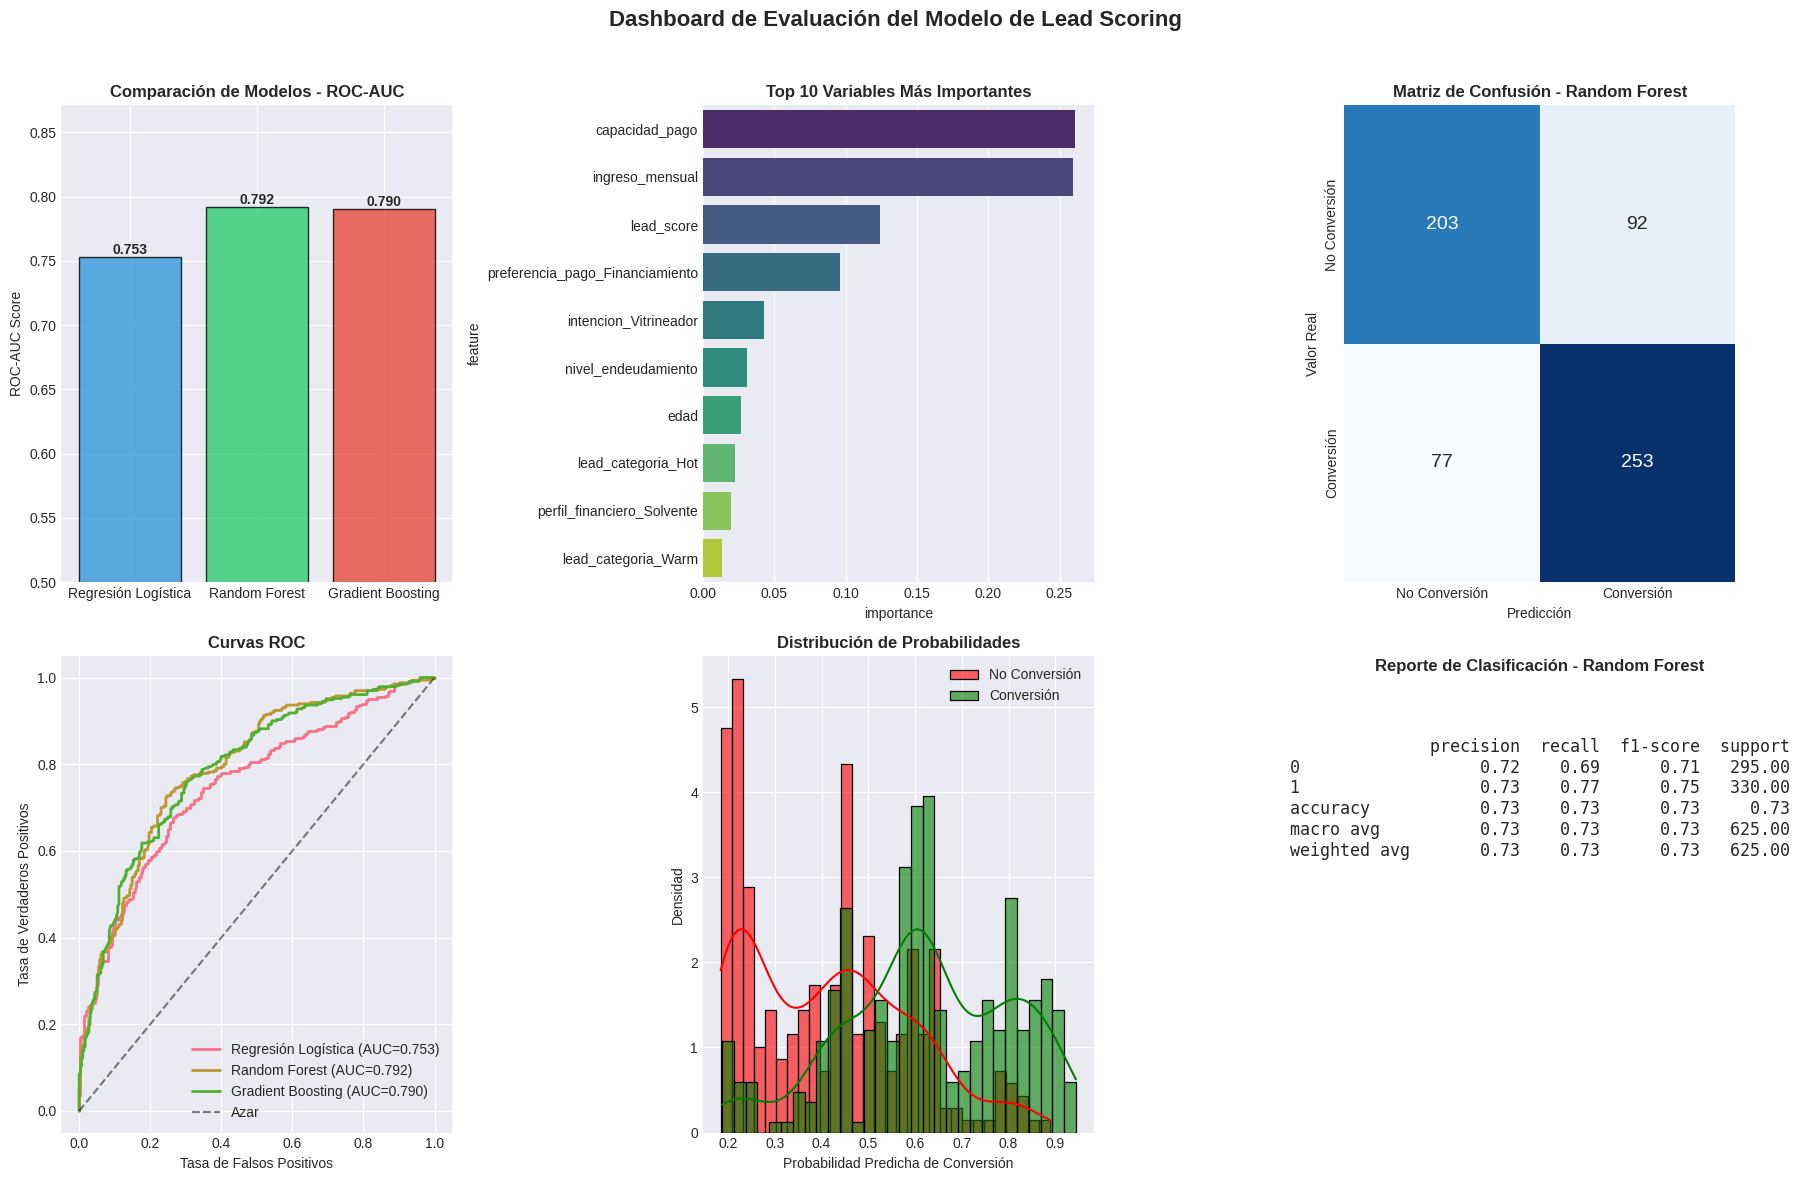

In [9]:
# ============================================================================
# 8. VISUALIZACIONES DE RESULTADOS
# ============================================================================

print("\n" + "="*80)
print("GENERANDO VISUALIZACIONES DE RESULTADOS")
print("="*80)

fig = plt.figure(figsize=(18, 12))
fig.suptitle('Dashboard de Evaluación del Modelo de Lead Scoring', fontsize=16, fontweight='bold')

# 1. Comparación de modelos
ax1 = plt.subplot(2, 3, 1)
modelos_nombres = list(resultados.keys())
roc_aucs = [resultados[m]['roc_auc'] for m in modelos_nombres]
colors = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax1.bar(modelos_nombres, roc_aucs, color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('ROC-AUC Score')
ax1.set_title('Comparación de Modelos - ROC-AUC', fontweight='bold', fontsize=12)
ax1.set_ylim([0.5, max(roc_aucs) * 1.1])
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Feature Importance
if 'feature_importance' in locals():
    ax2 = plt.subplot(2, 3, 2)
    top_features = feature_importance.head(10)
    sns.barplot(x='importance', y='feature', data=top_features, ax=ax2, palette='viridis')
    ax2.set_title('Top 10 Variables Más Importantes', fontweight='bold', fontsize=12)

# 3. Matriz de Confusión
cm = confusion_matrix(y_test, resultados[mejor_modelo_nombre]['y_pred'])
ax3 = plt.subplot(2, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, cbar=False,
            xticklabels=['No Conversión', 'Conversión'],
            yticklabels=['No Conversión', 'Conversión'], annot_kws={"size": 14})
ax3.set_ylabel('Valor Real')
ax3.set_xlabel('Predicción')
ax3.set_title(f'Matriz de Confusión - {mejor_modelo_nombre}', fontweight='bold', fontsize=12)

# 4. Curva ROC
ax4 = plt.subplot(2, 3, 4)
for nombre, res in resultados.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_pred_proba'])
    ax4.plot(fpr, tpr, label=f"{nombre} (AUC={res['roc_auc']:.3f})", linewidth=2)
ax4.plot([0, 1], [0, 1], 'k--', label='Azar', alpha=0.5)
ax4.set_xlabel('Tasa de Falsos Positivos')
ax4.set_ylabel('Tasa de Verdaderos Positivos')
ax4.set_title('Curvas ROC', fontweight='bold', fontsize=12)
ax4.legend(loc='lower right')

# 5. Distribución de probabilidades
ax5 = plt.subplot(2, 3, 5)
proba_conv = resultados[mejor_modelo_nombre]['y_pred_proba'][y_test == 1]
proba_no_conv = resultados[mejor_modelo_nombre]['y_pred_proba'][y_test == 0]
sns.histplot(proba_no_conv, bins=30, alpha=0.6, label='No Conversión', color='red', ax=ax5, stat='density', kde=True)
sns.histplot(proba_conv, bins=30, alpha=0.6, label='Conversión', color='green', ax=ax5, stat='density', kde=True)
ax5.set_xlabel('Probabilidad Predicha de Conversión')
ax5.set_ylabel('Densidad')
ax5.set_title('Distribución de Probabilidades', fontweight='bold', fontsize=12)
ax5.legend()

# 6. Reporte de Clasificación
ax6 = plt.subplot(2, 3, 6)
report = classification_report(y_test, resultados[mejor_modelo_nombre]['y_pred'], output_dict=True)
report_df = pd.DataFrame(report).transpose().round(2)
ax6.axis('off')
ax6.text(0.5, 0.7, str(report_df), ha='center', va='center', size=12, fontfamily='monospace')
ax6.set_title(f'Reporte de Clasificación - {mejor_modelo_nombre}', fontweight='bold', fontsize=12, y=0.95)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('lead_scoring_dashboard.png', dpi=300, bbox_inches='tight')
print("Dashboard de visualizaciones guardado en: lead_scoring_dashboard.png")

### **REPORTE EJECUTIVO**

In [10]:
# ============================================================================
# 9. REPORTE EJECUTIVO
# ============================================================================

print("\n" + "="*80)
print("REPORTE EJECUTIVO - INSIGHTS Y RECOMENDACIONES")
print("="*80)

print(f"""
RESUMEN DE RESULTADOS:
  - Total de leads analizados: {len(df)}
  - Tasa de conversión modelada: {tasa_conversion:.2f}%
  - Mejor modelo predictivo: {mejor_modelo_nombre}
  - Precisión (Accuracy) del modelo: {resultados[mejor_modelo_nombre]['accuracy']:.2%}
  - Capacidad de discriminación (ROC-AUC): {resultados[mejor_modelo_nombre]['roc_auc']:.4f}

VARIABLES CLAVE IDENTIFICADAS:
""")

if 'feature_importance' in locals():
    for _, row in feature_importance.head(5).iterrows():
        print(f"  - {row['feature']}: {row['importance']:.1%} de importancia")

print(f"""
RECOMENDACIONES ESTRATÉGICAS:

1. PRIORIZACIÓN INTELIGENTE DE LEADS:
   - Implementar el score del modelo para segmentar leads en tiempo real (ej: 'Hot', 'Warm', 'Cold').
   - Asignar los leads con mayor probabilidad (>75%) a los ejecutivos de venta más experimentados.

2. OPTIMIZACIÓN DEL PROCESO COMERCIAL:
   - Automatizar la calificación inicial para que el equipo se enfoque en la persuasión y cierre, no en el filtro.
   - Usar las variables clave para personalizar la comunicación. Si 'capacidad_pago' es alta, el enfoque debe ser en el valor y no en el precio.

3. ESTRATEGIAS BASADAS EN DATOS:
   - Para leads con probabilidad media (40-70%), realizar campañas de nurturing automatizadas para madurarlos.
   - Analizar los perfiles de los leads con baja probabilidad para identificar si hay un problema en la etapa de captación (marketing).

4. MEJORA CONTINUA DEL SISTEMA:
   - Re-entrenar el modelo trimestralmente con datos nuevos para que se adapte a cambios en el mercado.
   - Monitorear el rendimiento del modelo en producción para detectar una posible degradación (model drift).

IMPACTO POTENCIAL EN EL NEGOCIO:
  - Incremento medible en la tasa de conversión al enfocar recursos en los leads más prometedores.
  - Reducción del ciclo de venta al contactar leads con la información y el enfoque correctos desde el inicio.
  - Mejora del ROI de marketing al entender qué características de leads realmente convierten.
""")

print("\n" + "="*80)
print("ANÁLISIS COMPLETADO EXITOSAMENTE")
print("="*80)
print("\nPróximos pasos recomendados:")
print("1. Revisar las visualizaciones generadas (carpeta 'eda_plots' y 'lead_scoring_dashboard.png').")
print("2. Discutir los insights de 'Feature Importance' con los equipos de Ventas y Marketing.")
print("3. Planificar una prueba piloto (A/B Test) para validar el impacto del modelo en un entorno real.")
print("4. Preparar la infraestructura para la implementación del modelo en producción.")


REPORTE EJECUTIVO - INSIGHTS Y RECOMENDACIONES

RESUMEN DE RESULTADOS:
  - Total de leads analizados: 2500
  - Tasa de conversión modelada: 52.88%
  - Mejor modelo predictivo: Random Forest
  - Precisión (Accuracy) del modelo: 72.96%
  - Capacidad de discriminación (ROC-AUC): 0.7918

VARIABLES CLAVE IDENTIFICADAS:

  - capacidad_pago: 26.1% de importancia
  - ingreso_mensual: 26.0% de importancia
  - lead_score: 12.4% de importancia
  - preferencia_pago_Financiamiento: 9.6% de importancia
  - intencion_Vitrineador: 4.3% de importancia

RECOMENDACIONES ESTRATÉGICAS:

1. PRIORIZACIÓN INTELIGENTE DE LEADS:
   - Implementar el score del modelo para segmentar leads en tiempo real (ej: 'Hot', 'Warm', 'Cold').
   - Asignar los leads con mayor probabilidad (>75%) a los ejecutivos de venta más experimentados.

2. OPTIMIZACIÓN DEL PROCESO COMERCIAL:
   - Automatizar la calificación inicial para que el equipo se enfoque en la persuasión y cierre, no en el filtro.
   - Usar las variables clave pa